In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load all the data files
agency = pd.read_csv('agency.txt')
calendar = pd.read_csv('calendar.txt')
fare_attributes = pd.read_csv('fare_attributes.txt')
fare_rules = pd.read_csv('fare_rules.txt')
routes = pd.read_csv('routes.txt')
stop_times = pd.read_csv('stop_times.txt')
stops = pd.read_csv('stops.txt')
trips = pd.read_csv('trips.txt')

In [4]:
# Overview of the data in all the files

data_overview = {
    "agency":agency.head(),
    "calendar":calendar.head(),
    "routes":routes.head(),
    "fare_attributes":fare_attributes.head(),
    "fare_rules":fare_rules.head(),
    "stop_times":stop_times.head(),
    "stops":stops.head(),
    "trips":trips.head()
}

data_overview

{'agency':   agency_id           agency_name               agency_url agency_timezone  \
 0      HMRL  Hyderabad Metro Rail  https://www.ltmetro.com    Asia/Kolkata   
 
   agency_lang                     agency_fare_url  \
 0          en  https://www.ltmetro.com/ticketing/   
 
                   agency_email    agency_phone  
 0  customerservice@ltmetro.com  +91-4023332555  ,
 'calendar':   service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
 0         WK       1        1          1         1       1         1       1   
 1         SA       0        0          0         0       0         1       0   
 2         SU       0        0          0         0       0         0       1   
 
    start_date  end_date  
 0    20240906  20300101  
 1    20240906  20300101  
 2    20240906  20300101  ,
 'routes':   route_id agency_id route_short_name  \
 0      RED      HMRL           C1_RED   
 1    GREEN      HMRL         C2_GREEN   
 2     BLUE      HMRL          C3_BL

In [5]:
#stops.isnull().sum()

In [6]:
#fare_rules

In [7]:
# merge trips with calendar to include the day of operation information
trips_calendar = pd.merge(trips, calendar, on='service_id', how='left')

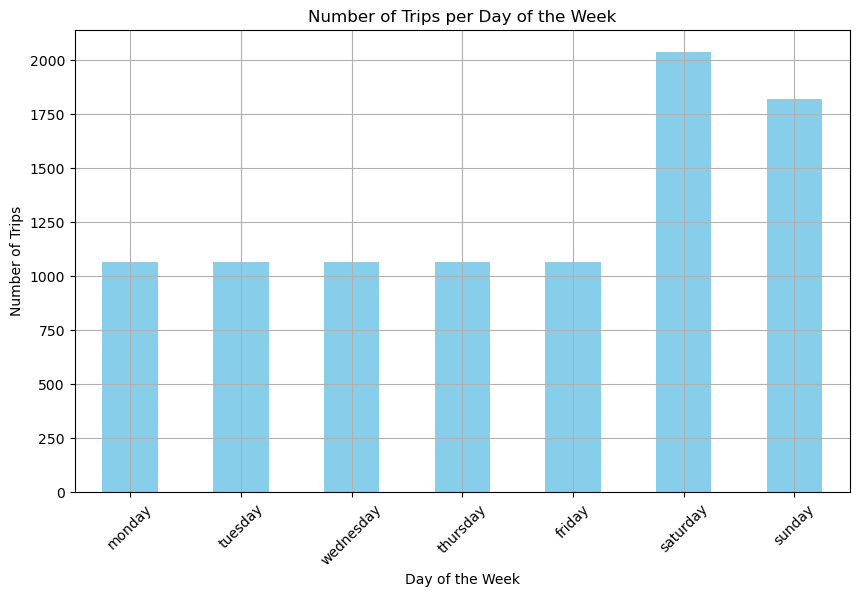

In [8]:
# count the number of trips per day of the week
trip_counts = trips_calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum()

# Plotting
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The Weekday scheduling of trips is consistent but is low compared to the Weekends with Saturday being the highest.

*This might be an operational miss with weekdays can be higher in terms of the number of Trips*

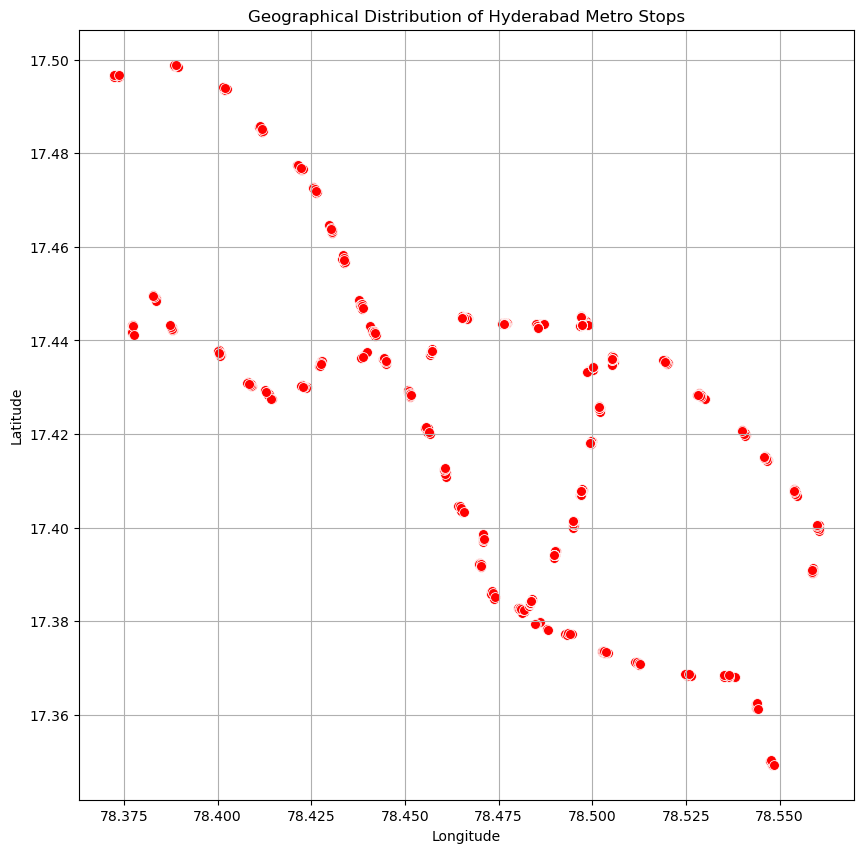

In [9]:
# plotting the locations of the stops
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', data=stops, color='red', s=50, marker='o')
plt.title('Geographical Distribution of Hyderabad Metro Stops')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [22]:
stops['stopping_id'] = stops['stop_id'].str.slice(stop=3)
#stops

In [23]:
stop_times['stopping_id'] = stop_times['stop_id'].str.slice(stop=3)

In [12]:
#stop_times

In [13]:
#pd.merge(stop_times, trips, on='trip_id')

In [14]:
#stops_with_routes.groupby('stop_id')

In [15]:
#stops_with_routes.groupby('stop_id')['route_id'].count()

In [24]:
stops_with_routes['stopping_id'] = stops_with_routes['stop_id'].str.slice(stop=3)

In [17]:
#stops_with_routes

In [18]:
#stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')
#stops_with_routes

In [19]:
#stop_route_counts = stops_with_routes.groupby('stopping_id')['route_id'].nunique().reset_index()

#stop_route_counts

In [20]:
#stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')
#stop_route_counts

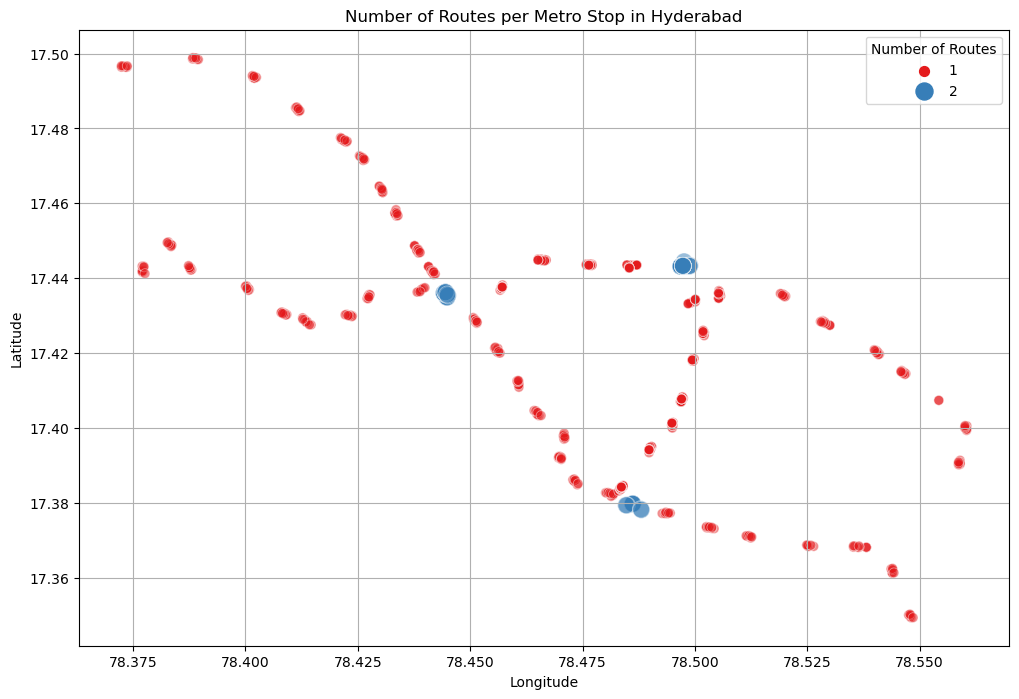

In [25]:
# merge stops with stop_times to link each stop with trips, and then merge with trips to get route information
stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')

# count how many unique routes pass through each stop
stop_route_counts = stops_with_routes.groupby('stopping_id')['route_id'].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})

# merge this with stops to get the names and location for plotting
stop_route_counts = pd.merge(stop_route_counts, stops, on='stopping_id')

# plot the number of routes per stop
plt.figure(figsize=(12, 8))
sns.scatterplot(x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes',
                sizes=(50, 150), alpha=0.5, palette='Set1', data=stop_route_counts)
plt.title('Number of Routes per Metro Stop in Hyderabad')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Number of Routes')
plt.grid(True)
plt.show()

The BLUE dots indicate Hub points or Transfer Junctions along the network which are mainly spread across 3 different routes.

There is an even distribution of stops number along the network indicating good coverage of the city.

C:\Users\vrt05\AppData\Local\Temp\ipykernel_1860\2659891260.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)


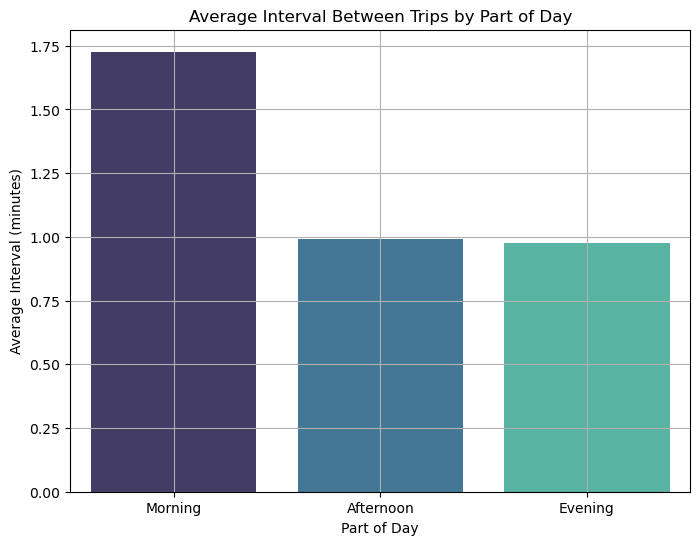

In [26]:
# converting stop_times 'arrival_time' from string to datetime.time for easier manipulation
import datetime as dt

# function to convert time string to datetime.time
def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        # Handle cases where the hour might be greater than 23 (e.g., 24:00:00 or 25:00:00)
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)

# calculate the difference in arrival times for subsequent trips at each stop
stop_times_sorted = stop_times.sort_values(by=['stopping_id', 'arrival_time_dt'])
stop_times_sorted['next_arrival_time'] = stop_times_sorted.groupby('stopping_id')['arrival_time_dt'].shift(-1)

# function to calculate the difference in minutes between two times
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    full_date_time1 = dt.datetime.combine(dt.date.today(), time1)
    full_date_time2 = dt.datetime.combine(dt.date.today(), time2)
    return (full_date_time2 - full_date_time1).seconds / 60

stop_times_sorted['interval_minutes'] = stop_times_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis=1)

# drop NaN values from intervals (last trip of the day)
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

# average intervals by time of day (morning, afternoon, evening)
def part_of_day(time):
    if time < dt.time(12, 0):
        return 'Morning'
    elif time < dt.time(17, 0):
        return 'Afternoon'
    else:
        return 'Evening'

stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='mako')
plt.title('Average Interval Between Trips by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Average Interval (minutes)')
plt.grid(True)
plt.show()

The Average interval between trips is at the highest during Morning and is lowest at Evening which could be to the overcrowding.

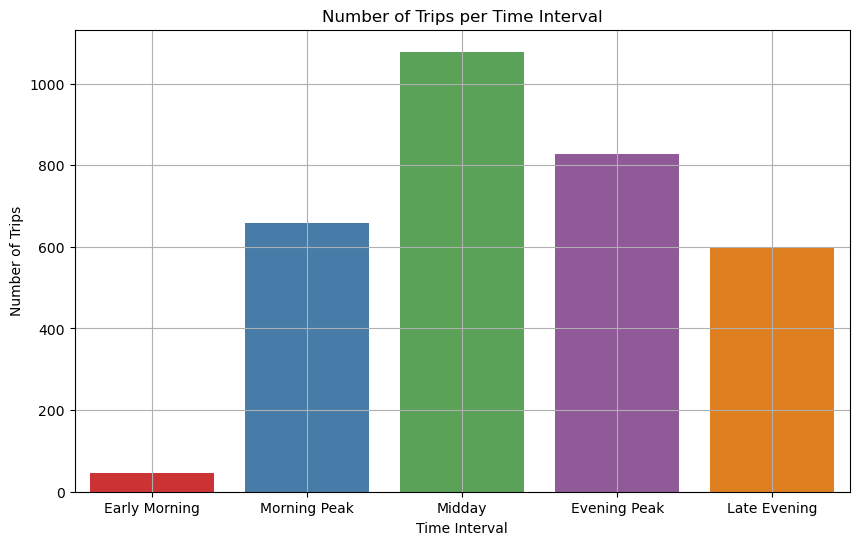

In [27]:
# define time intervals for classification
def classify_time_interval(time):
    if time < dt.time(6, 0):
        return 'Early Morning'
    elif time < dt.time(10, 0):
        return 'Morning Peak'
    elif time < dt.time(16, 0):
        return 'Midday'
    elif time < dt.time(20, 0):
        return 'Evening Peak'
    else:
        return 'Late Evening'

# apply time interval classification
stop_times['time_interval'] = stop_times['arrival_time_dt'].apply(classify_time_interval)

# count the number of trips per time interval
trips_per_interval = stop_times.groupby('time_interval')['trip_id'].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={'trip_id': 'number_of_trips'})

# sorting the dataframe
ordered_intervals = ['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']
trips_per_interval['time_interval'] = pd.Categorical(trips_per_interval['time_interval'], categories=ordered_intervals, ordered=True)
trips_per_interval = trips_per_interval.sort_values('time_interval')

# plotting the number of trips per time interval
plt.figure(figsize=(10, 6))
sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette='Set1')
plt.title('Number of Trips per Time Interval')
plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

The highest trips are conducted during Mid-day i.e., between 10 AM to 4 PM then gradually it decreases.

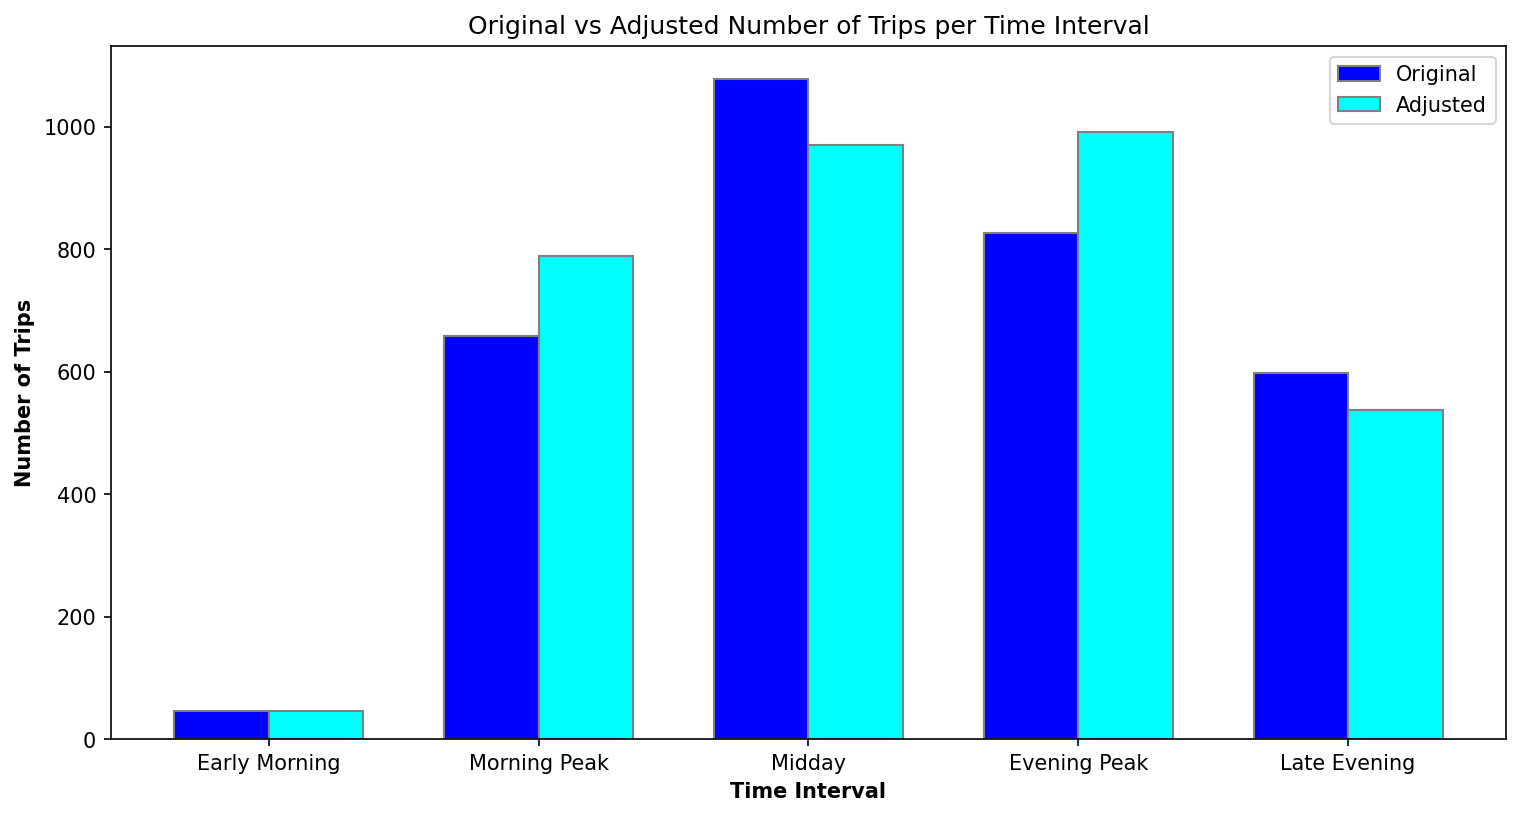

In [28]:
# adjusting frequencies based on hypothetical scenario
adjusted_trips_per_interval = trips_per_interval.copy()
adjustment_factors = {'Morning Peak': 1.20, 'Evening Peak': 1.20, 'Midday': 0.90, 'Early Morning': 1.0, 'Late Evening': 0.90}

# apply the adjustments
adjusted_trips_per_interval['adjusted_number_of_trips'] = adjusted_trips_per_interval.apply(
    lambda row: int(row['number_of_trips'] * adjustment_factors[row['time_interval']]), axis=1)

# plotting original vs adjusted number of trips per time interval
plt.figure(figsize=(12, 6),dpi=150)
bar_width = 0.35
r1 = range(len(adjusted_trips_per_interval))
r2 = [x + bar_width for x in r1]

plt.bar(r1, adjusted_trips_per_interval['number_of_trips'], color='blue', width=bar_width, edgecolor='grey', label='Original')
plt.bar(r2, adjusted_trips_per_interval['adjusted_number_of_trips'], color='cyan', width=bar_width, edgecolor='grey', label='Adjusted')

plt.xlabel('Time Interval', fontweight='bold')
plt.ylabel('Number of Trips', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(adjusted_trips_per_interval))], adjusted_trips_per_interval['time_interval'])
plt.title('Original vs Adjusted Number of Trips per Time Interval')
plt.legend()

plt.show()

In [29]:
fare_rules

,origin_id,destination_id,fare_id
0,NAG,NAG,F_10
1,UPL,NAG,F_10
2,STD,NAG,F_15
3,NGR,NAG,F_15
4,HSG,NAG,F_25
...,...,...,...
3476,RTC,MGB_G,F_15
3477,CDP,MGB_G,F_15
3478,NAR,MGB_G,F_15
3479,SUB,MGB_G,F_10


In [31]:
stops['stopping_id']

0      MYP
1      MYP
2      MYP
3      JNT
4      JNT
      ... 
700    RDG
701    RDG
702    RDG
703    RDG
704    RDG
Name: stopping_id, Length: 705, dtype: object